## Inspect data

In [13]:
import json
from constants import TEXTS_DIR, PERSPECTIVE_API_RESPONSE_DIR

In [14]:
# Print sample text
sample_text_file = TEXTS_DIR / '0000108-c17b018a21dba0c9c84e5f6dca782cbd.txt'
sample_text_file.read_text()

'WASHINGTON (Reuters) - Telecommunications giant AT&T struck back on Wednesday at Sen. Herb Kohl, chair of a congressional antitrust panel, saying the lawmaker’s concerns about a lack of competition in the wireless industry were unfounded.\n\nKohl wrote to the Justice Department’s top antitrust regulator Christine Varney and Federal Communications Commission Chairman Julius Genachowski on Monday to reiterate concerns over texting prices, large carriers failing to cooperate with smaller carriers to resolve roaming disputes, disputes over spectrum and deals that give one or another carrier exclusive access to popular phones like the iPhone.\n\nAT&T argued that cell service had become progressively cheaper, with revenue per minute falling 89 percent since 1994.\n\n“U.S. wireless prices are much lower than in any other major industrialized country,” wrote James Cicconi, an AT&T senior executive vice president.\n\nCicconi argued that texting prices had fallen because of package deals, “drop

In [15]:
# Print sample response
sample_response_file = PERSPECTIVE_API_RESPONSE_DIR / '0000108-c17b018a21dba0c9c84e5f6dca782cbd.txt.json'

with sample_response_file.open() as f:
    sample_response = json.load(f)

sample_response

{'attributeScores': {'TOXICITY': {'spanScores': [{'begin': 0,
     'end': 2504,
     'score': {'value': 0.09871901, 'type': 'PROBABILITY'}}],
   'summaryScore': {'value': 0.09871901, 'type': 'PROBABILITY'}}},
 'languages': ['en'],
 'detectedLanguages': ['en']}

## Load into pandas

In [16]:
%matplotlib inline
import pandas as pd
from pathlib import Path
import os
from constants import TOXICITY_SCORES_PICKLE

In [17]:
# Load Perspective API responses into dataframe

if not TOXICITY_SCORES_PICKLE.exists():
    rows = []

    for toxicity_file in PERSPECTIVE_API_RESPONSE_DIR.iterdir():
        if toxicity_file.suffix != '.json':
            continue

        toxicity_json = json.load(toxicity_file.open())
        toxicity_score = toxicity_json['attributeScores']['TOXICITY']['summaryScore']['value']

        text_filename = toxicity_file.name[:-5]
        assert text_filename.endswith('.txt')
        text_file = TEXTS_DIR / text_filename
        text = text_file.read_text()

        rows.append([text_filename, toxicity_score, text])

    df = pd.DataFrame(rows, columns=['filename', 'toxicity_score', 'text'])
    
    # Save a pickle for later
    df.to_pickle(TOXICITY_SCORES_PICKLE)
else:
    df = pd.read_pickle(TOXICITY_SCORES_PICKLE)

## Basic Analysis

In [18]:
# Data sorted by toxicity
df.sort_values(by=['toxicity_score'], ascending=False).head(10)

,filename,toxicity_score,text
131494,0490610-99f159c7a4b9868addbda9199cb17cdf.txt,0.990670,"FUCK /u/SPEZ , YOU FUCKING WORTHLESS CUCK FUCK..."
90904,0672031-2e34d061fc3c5e59d8730115bf3ef6b5.txt,0.947267,From fucking fbombingmom:\n\nI’d like to submi...
91076,0015608-1d7d2627e8be693ee345f6c5a4a79786.txt,0.946782,"'No, Really, Fuck Every One Of You'\n\nWASHING..."
58110,0278354-b3bdb61b43e24d62f7a1cbc88c41598c.txt,0.946288,Air America's Randi Rhodes said suspended for ...
31434,0005265-30f6c1242730bf4f9ef4ac0a65b785a7.txt,0.927032,"Jang Moonbok, the “fuckboy” from ‘God Of Music..."
19932,0764561-709f4ecb3166356dd57ecac7e266f858.txt,0.921134,You probably heard about the deranged sorority...
61286,0027620-b27d673c1fb056b708559632f7f0ca9b.txt,0.907830,Evan Brunell is a baseball writer and the pres...
47382,0092718-0b244361bde2506bb51478de5777712b.txt,0.899773,\n\nDoes your vagina have a brand?\n\nLet your...
5060,0159720-0dffc558696a5a22303ef62e0faa1f83.txt,0.899565,feminismisimportantlove:\n\ndanny-dice:\n\nfem...
102015,0955335-decce7189212838edb4fae8130e9977e.txt,0.899428,Login to vote this up!\n\nSo my brother just l...


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fdcd16b0b90>]],
      dtype=object)

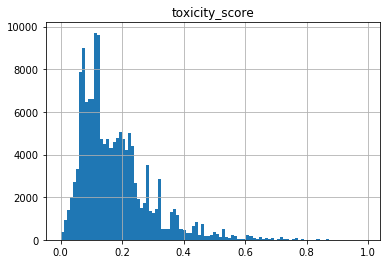

In [19]:
# Histogram of toxicity scores
# TODO: norm
df.hist(column='toxicity_score', bins=100)

In [20]:
df['text'][0]

'PC leadership hopefuls bring little to race\n\nChow as NDP leader changes the equation\n\nTORONTO November 1st, 2014 – In a random sampling of public opinion taken by the Forum Poll™ among 1104 Ontario voters, vote shares for the Progressive Conservative party are lower when actual leadership contenders are named than when no leader is named, but when Olivia Chow is proposed as leader of the Ontario New Democrats, the balance of probabilities changes considerably.\n\nLiberals with 5 point lead in generic horserace\n\nIn the generic horserace, where no leaders are named, results are very similar to the recent election, and 4-in-10 will vote Liberal if a provincial election were held today (40%), while just more than a third will vote PC (35%). In this scenario, the NDP take a fifth of the vote (19%), and the Greens (4%) and other parties take few (2%).\n\n\n\n\n\nTwo seat majority seen for Liberals\n\nIf these results were projected up to seats in a 107 seat Legislature, the Liberals w

# TF-IDF

In [17]:
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer

In [18]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df["text"])

feature_names = vectorizer.get_feature_names()

In [114]:
df_idf = pd.DataFrame(vectorizer.idf_, index=feature_names, columns=["idf_weights"])
df_idf.sort_values(by=['idf_weights'], ascending=False).head()

,idf_weights
kohime,12.22005
modeswitch,12.22005
modesta,12.22005
modess,12.22005
modeshare,12.22005


In [106]:
def get_idf_score(filename):
    idx = df[df['filename'] == filename].index
    document_vector = X[idx]
    df_tfidf = pd.DataFrame(document_vector.T.todense(), index=feature_names, columns=["tfidf"])
    return df_tfidf.sort_values(by=["tfidf"],ascending=False)


get_idf_score('0672031-2e34d061fc3c5e59d8730115bf3ef6b5.txt').head()

,tfidf
fucking,0.745171
fuckin,0.372744
hate,0.214885
bitches,0.171338
fuck,0.157150


In [116]:
get_idf_score('0189902-976e23a79df312f42c99556b1efe11e1.txt').head()

,tfidf
detective,0.450615
amnesty,0.290715
freerepublic,0.227429
the,0.204532
immigrants,0.196617


## URLs

In [21]:
from constants import URLS_PICKLE

In [26]:
import tldextract

def get_domain(url):
    ext = tldextract.extract(url)
    return ext.domain + '.' + ext.suffix

In [27]:
df_urls = pd.read_pickle(URLS_PICKLE)
df_urls['url'] = df_urls['url'].apply(lambda url: get_domain(url))
df_urls.head()

,url,filename
0,guardian.co.uk,0610905-8d5bdc4f88bed43e4f5f606a43bf4d61.txt
1,links.org.au,0147024-8b731d228ad09fcff1cc3ed6e06450bb.txt
2,tricycle.com,0286995-93a6dcb796e6448bbeebd07b5379956d.txt
3,sciencebasedmedicine.org,0155423-cb5aead54795dbfc57a56ccd1dab5830.txt
4,itbusiness.ca,0019075-4f9b2593bd76ccdd1aede0c220045cec.txt


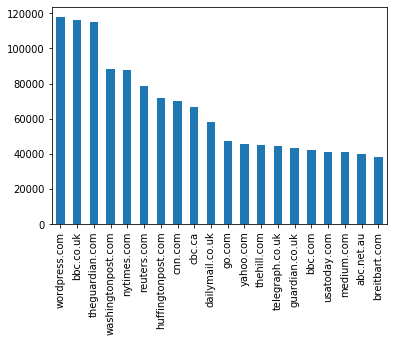

In [44]:
df_urls['url'].value_counts()[:20].plot(kind='bar')

In [49]:
len(df_urls[df_urls['url'] == 'naturalnews.com'])

2551

In [28]:
df_perspective_urls = df.merge(df_urls)
df_perspective_urls['url'] = df_perspective_urls['url'].apply(lambda url: get_domain(url))
df_perspective_urls.head()

,filename,toxicity_score,text,url
0,0588122-39c89eab36c8e7ffbb186065859a61ea.txt,0.148575,PC leadership hopefuls bring little to race\n\...,forumresearch.com
1,0699789-3dd960adbd5560666704394b0ab29b70.txt,0.142957,Washington (AFP) - Women who eat instant noodl...,yahoo.com
2,0068409-262de9c4f7a1a1cde56395e25bcea8b3.txt,0.113665,City officials in Los Angeles have been trying...,foxnews.com
3,0654776-9f899c92584aa96f699bf659ce88590b.txt,0.167665,Part seven of the Washington Examiner's 10-par...,washingtonexaminer.com
4,0565971-a9e9785925f9f9c4f3ae642e22e5eadf.txt,0.259815,SIX boys aged 15 and 16 have been questioned o...,thesun.co.uk


# Styles

In [79]:
df[df['text'].str.contains('illegals') & (df['toxicity_score'] > 0.5)]

,filename,toxicity_score,text
4536,0493193-cbee454bc487742db2744e72df23161c.txt,0.530944,Hillary Clinton's suicide pact for destroying ...
50599,0021233-c3a86ff0df84b24f3c6e86bf449a9573.txt,0.549550,Change And The Chosen Path\n\nThe psychology o...
55176,0961802-907d9512a1cedfa297bbc9d85c59f8a3.txt,0.637247,As his bid to become Texas' next governor ramp...
58323,0525847-7446eeaec551e9dcd39b68c4744e7be9.txt,0.639702,"1. Horn, And the Walls of Cuckdom began to cru..."
108430,0470119-80c75d3729f47de88c86f1a00ff928a8.txt,0.531471,With the San Francisco woman murdered by one o...


In [83]:
print(df.iloc[4536]['text'])

Hillary Clinton's suicide pact for destroying America

Liberalism is an auto-immune disorder

No matter who gets elected, NEVER give up your Second Amendment... and keep stockpiling guns and ammo for the day you need to defend your nation against all enemies

(NaturalNews) We saw it all in the debate last night. Hillary Clinton wants background checks for gun purchases but not for immigrants. She's completely clueless about why Obamacare is imploding and wants us all to believe that her NEW promises on "fixing" the failed system will be more credible than the OLD promises that turned out to be fraudulent lies. Hillary Clinton is a congenital liar who lies about lying. When caught lying, she proclaims her accuser is the liar and that she alone has a monopoly on the truth. But it's far worse than that, really. When you look at her policies, the "hatred in her heart" pointed out by Trump, the criminality, the money laundering, the threats against female victims of Bill's sexual assaults, 